<a href="https://colab.research.google.com/github/adhilabu/ai-ml-learning-training/blob/main/Llama_3_2_Vision_Finetuning_Unsloth_PAN_CARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to assist medical professionals in analyzing xrays, CT scans & ultrasounds.**

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.17: Fast Mllama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset
huggingface_token=""
dataset = load_dataset("rapidoradhilabacker/docs", split="train", token=True)

README.md:   0%|          | 0.00/418 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/827k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11 [00:00<?, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [ ]:
dataset

Dataset({
    features: ['image', 'objects'],
    num_rows: 11
})

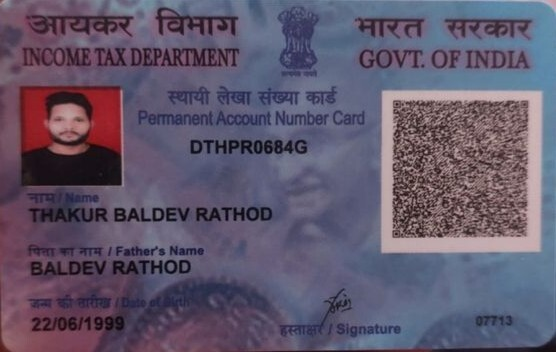

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["objects"]

[{'bbox': [72, 30, 240, 38],
  'category': 'Department',
  'text': 'INCOME TAX DEPARTMENT'},
 {'bbox': [330, 30, 170, 38],
  'category': 'Government',
  'text': 'GOVT. OF INDIA'},
 {'bbox': [72, 100, 240, 38],
  'category': 'CardType',
  'text': 'Permanent Account Number Card'},
 {'bbox': [200, 140, 100, 38], 'category': 'PAN', 'text': 'DTHPR0684G'},
 {'bbox': [72, 200, 240, 38],
  'category': 'Name',
  'text': 'THAKUR BALDEV RATHOD'},
 {'bbox': [72, 250, 240, 38],
  'category': 'FatherName',
  'text': 'BALDEV RATHOD'},
 {'bbox': [72, 300, 240, 38], 'category': 'DateOfBirth', 'text': '22/06/1999'}]

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
import json

# Enhanced instruction with bounding box references
instruction = """You are an expert in Indian PAN card document analysis.
Examine this PAN card image carefully and extract the following information from these specific regions:

1. PAN number: Usually located near coordinates [200, 140, 100, 38]
   - Format: 5 uppercase letters + 4 digits + 1 uppercase letter

2. Name of the cardholder: Usually located near coordinates [72, 200, 240, 38]
   - Full name as printed on the card

3. Father's name: Usually located near coordinates [72, 250, 240, 38]
   - Complete name of the cardholder's father

4. Date of Birth: Usually located near coordinates [72, 300, 240, 38]
   - Format: DD/MM/YYYY

Return ONLY a JSON object with these four fields using the exact format:
{
  "pan_number": "extracted PAN",
  "name": "extracted name",
  "fathers_name": "extracted father's name",
  "dob": "extracted date of birth"
}"""

def convert_to_conversation(sample):
    """
    Convert a sample with image and objects to the proper conversation format
    required for vision model fine-tuning. Includes bounding box reference info.

    Args:
        sample: Dictionary containing 'image' and 'objects' fields

    Returns:
        Dictionary with 'messages' field containing the formatted conversation
    """
    # Extract relevant information from the objects
    pan_data = {}
    bbox_info = {}

    # Process each detected object from the PAN card and store bbox info
    for obj in sample["objects"]:
        category = obj["category"]
        text = obj["text"]
        bbox = obj["bbox"]

        # Store the bounding box information for reference
        bbox_info[category] = bbox

        # Map to the desired output format
        if category == "PAN":
            pan_data["pan_number"] = text
        elif category == "Name":
            pan_data["name"] = text
        elif category == "FatherName":
            pan_data["fathers_name"] = text
        elif category == "DateOfBirth":
            pan_data["dob"] = text

    # Create an enhanced instruction with the specific bounding box values from this sample
    enhanced_instruction = f"""You are an expert in Indian PAN card document analysis.
Examine this PAN card image carefully and extract the following information from these specific regions:

1. PAN number: Located near coordinates {bbox_info.get('PAN', '[200, 140, 100, 38]')}
   - Format: 5 uppercase letters + 4 digits + 1 uppercase letter
   - Example: ABCDE1234F

2. Name of the cardholder: Located near coordinates {bbox_info.get('Name', '[72, 200, 240, 38]')}
   - Full name as printed on the card

3. Father's name: Located near coordinates {bbox_info.get('FatherName', '[72, 250, 240, 38]')}
   - Complete name of the cardholder's father

4. Date of Birth: Located near coordinates {bbox_info.get('DateOfBirth', '[72, 300, 240, 38]')}
   - Format: DD/MM/YYYY

Return ONLY a JSON object with these four fields using the exact format:
{{
  "pan_number": "{pan_data.get('pan_number', '')}",
  "name": "{pan_data.get('name', '')}",
  "fathers_name": "{pan_data.get('fathers_name', '')}",
  "dob": "{pan_data.get('dob', '')}"
}}"""

    # Format the expected answer as a JSON string
    answer = json.dumps(pan_data, indent=2)

    # Create the conversation in the required format for fine-tuning
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": enhanced_instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": answer}
            ]
        },
    ]

    return {"messages": conversation}

# Alternative approach with explicit bbox guidance in the conversation
def convert_to_conversation_with_bbox_context(sample):
    """
    Alternative approach that creates a training sample with the model having
    to first identify the bounding boxes and then extract the information.

    Args:
        sample: Dictionary containing 'image' and 'objects' fields

    Returns:
        Dictionary with 'messages' field containing a multi-turn conversation
    """
    # Basic instruction for first turn
    initial_instruction = """You are an expert in Indian PAN card document analysis.
First, identify the bounding box coordinates of these key elements in the PAN card image:
1. PAN Number
2. Name
3. Father's Name
4. Date of Birth

Return the bounding boxes in this format:
{
  "PAN": [x, y, width, height],
  "Name": [x, y, width, height],
  "FatherName": [x, y, width, height],
  "DateOfBirth": [x, y, width, height]
}"""

    # Create a JSON of the bounding boxes
    bbox_data = {}
    for obj in sample["objects"]:
        if obj["category"] in ["PAN", "Name", "FatherName", "DateOfBirth"]:
            bbox_data[obj["category"]] = obj["bbox"]

    bbox_answer = json.dumps(bbox_data, indent=2)

    # Extract the actual values for the final answer
    pan_data = {}
    for obj in sample["objects"]:
        category = obj["category"]
        text = obj["text"]

        if category == "PAN":
            pan_data["pan_number"] = text
        elif category == "Name":
            pan_data["name"] = text
        elif category == "FatherName":
            pan_data["fathers_name"] = text
        elif category == "DateOfBirth":
            pan_data["dob"] = text

    final_answer = json.dumps(pan_data, indent=2)

    # Create a multi-turn conversation
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": initial_instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": bbox_answer}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Now extract the actual information from these regions and format it as specified."}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": final_answer}
            ]
        },
    ]

    return {"messages": conversation}

# Process the entire dataset
def prepare_dataset_for_finetuning(dataset, use_bbox_context=False):
    """
    Process the entire dataset for fine-tuning

    Args:
        dataset: List or iterator of samples with 'image' and 'objects'
        use_bbox_context: If True, use the multi-turn approach

    Returns:
        List of formatted conversations
    """
    if use_bbox_context:
        return [convert_to_conversation_with_bbox_context(sample) for sample in dataset]
    else:
        return [convert_to_conversation(sample) for sample in dataset]

# Example usage:
# formatted_dataset = prepare_dataset_for_finetuning(dataset)
# formatted_dataset_bbox = prepare_dataset_for_finetuning(dataset, use_bbox_context=True)

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = prepare_dataset_for_finetuning(dataset, use_bbox_context=True)

The first example is now structured like below:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert in Indian PAN card document analysis.\nFirst, identify the bounding box coordinates of these key elements in the PAN card image:\n1. PAN Number\n2. Name\n3. Father\'s Name\n4. Date of Birth\n\nReturn the bounding boxes in this format:\n{\n  "PAN": [x, y, width, height],\n  "Name": [x, y, width, height],\n  "FatherName": [x, y, width, height],\n  "DateOfBirth": [x, y, width, height]\n}'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=556x352>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{\n  "PAN": [\n    200,\n    140,\n    100,\n    38\n  ],\n  "Name": [\n    72,\n    200,\n    240,\n    38\n  ],\n  "FatherName": [\n    72,\n    250,\n    240,\n    38\n  ],\n  "DateOfBirth": [\n    72,\n    300,\n    240,\n    38\n  ]\n}'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Now extract the actual inform

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
import json


FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
# instruction = "You are an expert radiographer. Describe accurately what you see in this image."

# Define the output format template
json_template = {
    "pan_number": "",
    "name": "",
    "fathers_name": "",
    "dob": ""
}

# Create a more robust instruction
instruction = f"""
You are an expert at extracting information from Indian PAN (Permanent Account Number) cards. Carefully analyze the provided image and extract the following key details into JSON format.

Please return ONLY the completed JSON with these fields:
{json.dumps(json_template, indent=2)}

Extraction guidelines:

1. PAN Number:
   - Look for a 10-character alphanumeric code (Example format: AAAAA0000A - 5 letters, 4 digits, 1 letter)
   - It's typically labeled as "Permanent Account Number" or "पैन नंबर"
   - This is the most important identifier on the card
   - It may appear in large font or be highlighted in some way

2. Name:
   - The cardholder's full name
   - Usually appears after a label like "Name:" or "नाम:"
   - May be in all capital letters
   - Usually one of the first personal details on the card

3. Father's Name:
   - Look for text labeled as "Father's Name:" or "पिता का नाम:"
   - May be preceded by "S/O" (Son Of) or "D/O" (Daughter Of)
   - Usually appears below the cardholder's name

4. Date of Birth:
   - Look for text labeled as "Date of Birth:" or "जन्म तिथि:"
   - Format should be DD/MM/YYYY
   - May also appear as DD-MM-YYYY

Important instructions:
- Examine the ENTIRE image thoroughly, as PAN card layouts vary
- Focus on reading text accurately, especially the PAN number
- If any field cannot be clearly identified, leave it as an empty string
- Do not make assumptions about data you cannot clearly see
- Return ONLY the completed JSON without any explanations or additional text
- Pay special attention to different fonts, text styles, and potential watermarks that might obscure text
"""

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

To extract information from the PAN card, we need to analyze the provided image and extract the key details in JSON format. 

First, let's locate the PAN number, which is a 10-character alphanumeric code. It's typically labeled as "Permanent Account Number" or "पैन नंबर". The PAN number on this card is **DTHPR0684G**.

Next, let's identify the cardholder's full name. It usually appears after a label like "Name:" or "नाम:". The name on this card is **THAKUR BALDEV RATHOD**.

Then, let's find the Father's


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
9.068 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11 | Num Epochs = 30 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 52,428,800/11,000,000,000 (0.48% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.574400
2,1.812500
3,1.628900
4,1.573900
5,1.299600
6,0.978700
7,0.873100
8,0.659300
9,0.528400
10,0.394900


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

969.6321 seconds used for training.
16.16 minutes used for training.
Peak reserved memory = 10.693 GB.
Peak reserved memory for training = 1.625 GB.
Peak reserved memory % of max memory = 72.505 %.
Peak reserved memory for training % of max memory = 11.018 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
import json
from unsloth import FastVisionModel
from transformers import TextStreamer
from PIL import Image

# Enable the model for inference
FastVisionModel.for_inference(model)

# Select an image from the dataset
image_pth = "/content/my.png"
image = Image.open(image_pth)

# Define the output format template
json_template = {
    "pan_number": "",
    "name": "",
    "fathers_name": "",
    "dob": ""
}

# Create a more robust instruction
instruction = f"""
You are an expert at extracting information from Indian PAN (Permanent Account Number) cards. Carefully analyze the provided image and extract the following key details into JSON format.

Please return ONLY the completed JSON with these fields:
{json.dumps(json_template, indent=2)}

Extraction guidelines:

1. PAN Number:
   - Look for a 10-character alphanumeric code (format: AAAAA0000A - 5 letters, 4 digits, 1 letter)
   - It's typically labeled as "Permanent Account Number" or "पैन नंबर"
   - This is the most important identifier on the card
   - It may appear in large font or be highlighted in some way

2. Name:
   - The cardholder's full name
   - Usually appears after a label like "Name:" or "नाम:"
   - May be in all capital letters
   - Usually one of the first personal details on the card

3. Father's Name:
   - Look for text labeled as "Father's Name:" or "पिता का नाम:"
   - May be preceded by "S/O" (Son Of) or "D/O" (Daughter Of)
   - Usually appears below the cardholder's name

4. Date of Birth:
   - Look for text labeled as "Date of Birth:" or "जन्म तिथि:"
   - Format should be DD/MM/YYYY
   - May also appear as DD-MM-YYYY

Important instructions:
- Examine the ENTIRE image thoroughly, as PAN card layouts vary
- Focus on reading text accurately, especially the PAN number
- If any field cannot be clearly identified, leave it as an empty string
- Do not make assumptions about data you cannot clearly see
- Return ONLY the completed JSON without any explanations or additional text
- Pay special attention to different fonts, text styles, and potential watermarks that might obscure text
"""

# Format the input messages
messages = [
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": instruction}
    ]}
]

# Apply the chat template and tokenize the input
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# Generate the model's response
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=256,
    use_cache=True,
    temperature=0.1,  # Even lower temperature for more deterministic output
    top_p=0.9,        # Focus on higher probability tokens
    do_sample=True
)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."


messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The panoramic radiograph shows bilateral hypoplasia of the condylar heads and mandibular fossae in a patient with fibrodysplasia ossificans progressiva.<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>